# Manhattan K-Clustering Model

#### Skills: Python, Pandas, Matplotlib, Folium, Geopy, BeautifulSoup, Numpy

In this project, we'll analyze Manhattan data points and perform a K-Clustering Analysis using the Foursquare API to retrieve information on nearby business venues. The goal of this analysis is to group geographic datapoints to identify Manhattan areas that are similar to one another.
    
We'll use the following python add ins as a part of this analysis:

   * **Pandas:** data manipulation and analysis

   * **Folium:** create geographic visualizations

   * **Matplotlib:** enhance visualizations

   * **Geopy:** gather coordinates based upon addresses

   * **BeautifulSoup:** webscraping
   * **Numpy:** scientific computing


In [86]:
# Import libraries
import pandas as pd
import numpy as np 
import json 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
from geopy.distance import geodesic
import matplotlib.colors as colors
import sys
import requests
from sklearn.cluster import KMeans
import itertools
import folium
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import re
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt 
print('Libraries imported.')

Libraries imported.


## Part 1: Create Manhattan Data Points

First, we are going to create our initial dataset from scratch. The idea is to create a grid of evenly spaced latitude and longitude points so the entire island of Manhattan is covered. The final dataframe will consist of all the latitude and longitude points within this grid.

In [2]:
# Define the boundary points of the grid
botlat = 40.699657
toplat = 40.862651
leftlong = -74.019729
rightlong = -73.925556
# Calculate the space between each latitude and longitude values setting the grid demensions as 50 X 20
latdist = (toplat - botlat)/49
longdist = (rightlong - leftlong)/19

In [3]:
# Create a list with all latitude values
latlist = []
i = toplat + latdist
for x in range(0,50):
    i = i - latdist
    latlist.append(i)

In [4]:
# Create a list with all longtitude values
longlist = []
i = rightlong + longdist
for x in range(0,20):
    i = i - longdist
    longlist.append(i)

In [5]:
# Combine the latitude and longitude lists to create a set of lat/long datapoints
latlonglist = []
for a in latlist:
    for b in longlist:
        c = (a,b)
        latlonglist.append(c)

In [6]:
# Convert the datapoints into a pandas DataFrame
latlonggrid = pd.DataFrame(latlonglist,columns = ['Latitude','Longitude'])
latlonggrid.head(5)

,Latitude,Longitude
0,40.862651,-73.925556
1,40.862651,-73.930512
2,40.862651,-73.935469
3,40.862651,-73.940425
4,40.862651,-73.945382


To ensure this grid of latitude and longitude points were successfully created, the following function creates a map of New York displaying each of the created datapoints.

In [7]:
# Set map perameters
nylatitude = 40.758681
nylongitude = -73.983030
map_manhattan = folium.Map(location=[nylatitude, nylongitude], zoom_start=12)

# Add markers to map
for lat, lng in zip(latlonggrid['Latitude'], latlonggrid['Longitude']):
    label = '{},{}'.format(lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan

Now that a set of latitude and longitude points are successfully created, we must remove all datapoints outside of the Manhattan borders. In order to define the Manhatan boundaries, we retrieve a geojson file consisting of all New York City borough geographic borders.

In [8]:
# Get geojson data from html
response = requests.get("https://raw.githubusercontent.com/derekvogt3/Manhattan-K-Clustering-Model/master/nyc_pediacities_neighborhoods_v3_polygon.geojson")
nyc_geography = json.loads(response.text)

Since we are only performing an analysis on Manhattan data points, we must exclude the other 4 boroughs from the geojson file. In addition, we only want to look at the island of manhattan so the surrounding islands (Randall's Island, Ellis Island, Governors Island, etc.) are filtered out of the dataset. Central Park is also excluded as is not a neighborhood with residential/commercial buildings.

In [9]:
# Filter the geojson data to only include the 'Manhattan' borough
features = []
for k,v in itertools.groupby([x for x in nyc_geography['features'] if x['properties']['borough'] == 'Manhattan' ]): 
    features.append(k)
nyc_geography['features'] = features
# Filter the geojson data to remove out of scope manhattan neighborhoods
features = []
excludeneighborhood = ['Randall\'s Island','Ellis Island','Governors Island','Liberty Island','Roosevelt Island','Central Park']
for hood in excludeneighborhood:
    for k,v in itertools.groupby([x for x in nyc_geography['features'] if not x['properties']['neighborhood'] == hood ]): 
        features.append(k)
    nyc_geography['features'] = features
    features = []

In [10]:
# Create a numpy array to only include only the latitude and longitude points of each neighborhood shape
all_coordinates = []
all_coordinates_list = []
neighborhoodshape = []
for y in nyc_geography['features']:
    all_coordinates.append(y['geometry']['coordinates'])
for a in all_coordinates:
    for b in a:
        for c in b:
            element = pd.DataFrame(c).values
            neighborhoodshape.append(element)

The geojson file consists of coordinate data, grouped together by neighborhood to create a polygon. In order to determine if a data point is located in Manhattan, a function checks if a point is contain within a neighborhood polygon. By sorting the final dataframe for all "True" values, the final dataset will consist only of points located in Manhattan.

In [11]:
withinboundaries=[]
for lat, lon in zip(latlonggrid['Latitude'], latlonggrid['Longitude']):
    for a in neighborhoodshape:
        polygon = Polygon(a) # create polygon
        point = Point(lon,lat) # create point
        withinboundaries.append([point.within(polygon),lat,lon])#returns a boolian value if each 
withinboundaries = pd.DataFrame(withinboundaries,columns = ['TF','Latitude','Longitude'])
withinboundaries.head(5)

,TF,Latitude,Longitude
0,False,40.862651,-73.925556
1,False,40.862651,-73.925556
2,False,40.862651,-73.925556
3,False,40.862651,-73.925556
4,False,40.862651,-73.925556


In [12]:
# Filter for true values and remove the 'TF' column
nyc_nodes = withinboundaries[withinboundaries['TF']==True].reset_index(drop = True)
nyc_nodes = nyc_nodes.drop(columns = 'TF')
nyc_nodes.head(5)

,Latitude,Longitude
0,40.862651,-73.925556
1,40.862651,-73.930512
2,40.862651,-73.935469
3,40.859325,-73.925556
4,40.859325,-73.930512


Now that a dataframe is created with only Manhattan data points, each latitude and longitude value is assigned a unique identifier used in upcoming analysis.

In [13]:
# Set a Node ID for each datapoint
node_id_column = []
i = 0
for x in nyc_nodes['Latitude']:
    i = i+1
    node_id = "Node " + str(i)
    node_id_column.append(node_id)
nyc_nodes['Node ID'] = node_id_column
nyc_nodes.head(5)

,Latitude,Longitude,Node ID
0,40.862651,-73.925556,Node 1
1,40.862651,-73.930512,Node 2
2,40.862651,-73.935469,Node 3
3,40.859325,-73.925556,Node 4
4,40.859325,-73.930512,Node 5


As seen in the map below, all of the datapoints are located within the island of Manhattan which will be the basis of the K - clustering analysis.

In [14]:
nylatitude = 40.758681
nylongitude = -73.983030
map_manhattan = folium.Map(location=[nylatitude, nylongitude], zoom_start=12)

# add markers to map
for lat, lng in zip(nyc_nodes['Latitude'], nyc_nodes['Longitude']):
    label = '{},{}'.format(lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan

## Part 2: Retrieve Foursquare Data

The Foursquare API is a tool that allows us to get nearby venue information at a specific geographic point. Venues consist of any nearby business open to the public such as restaurants, theaters, and retail stores. 


In [15]:
#define Foursquare user credentials
CLIENT_ID = 'PQNXOZURH4NRHUZDE0MY3UJ0FRSLWD4PCYP51O20LGSNTLSG' # your Foursquare ID
CLIENT_SECRET = 'OLAOA0P1OEQTR4DLGKZNXM4WPFKBRK31C4BOTYGAPPGSCH2S' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: PQNXOZURH4NRHUZDE0MY3UJ0FRSLWD4PCYP51O20LGSNTLSG
CLIENT_SECRET:OLAOA0P1OEQTR4DLGKZNXM4WPFKBRK31C4BOTYGAPPGSCH2S


The function below retrieves nearby venues for each latitude and longitude point on the dataset created above.

In [93]:
# Set Foursquare API perameters
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 400 # define radius

def getNearbyVenues(latitudes, longitudes, node, radius=400):
    
    venues_list=[]
    for lat, lng, node in zip(latitudes, longitudes, node):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            node,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Node ID','Node Latitude', 
                  'Node Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [94]:
node_manhattan_venues = getNearbyVenues(node = nyc_nodes['Node ID'],latitudes=nyc_nodes['Latitude'],
                                   longitudes=nyc_nodes['Longitude']
                                  )

In [59]:
print(node_manhattan_venues.shape)
node_manhattan_venues.head()

(19601, 7)


,Node ID,Node Latitude,Node Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Node 1,40.862651,-73.925556,Pizza Palace,40.862414,-73.925134,Pizza Place
1,Node 1,40.862651,-73.925556,Cachapas y mas,40.862038,-73.924972,Latin American Restaurant
2,Node 1,40.862651,-73.925556,Siete Tacos,40.863739,-73.925539,Mexican Restaurant
3,Node 1,40.862651,-73.925556,Viva's Tapa & Lounge,40.863048,-73.926581,Tapas Restaurant
4,Node 1,40.862651,-73.925556,Tryon Public House,40.865123,-73.928004,Pub


In [61]:
print('There are {} uniques categories.'.format(len(node_manhattan_venues['Venue Category'].unique())))

There are 417 uniques categories.


In order to reformat the data for our K - clustering analaysis, we need to convert the catagorial variales into indicator variables. Since there are 417 unique categories, we expect 418 columns in our table (Venue Categories + Node ID).

In [62]:
# one hot encoding
manhattan_onehot = pd.get_dummies(node_manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add 'Node ID' column back to dataframe
manhattan_onehot['Node ID'] = node_manhattan_venues['Node ID'] 

# move 'Node ID' column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Node ID,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Node 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Node 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Node 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Node 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Node 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
manhattan_onehot.shape

(19601, 418)

Next, we further prepare the dataset by finding the average occurance for each venuetype and group by 'Node ID'

In [64]:
manhattan_grouped = manhattan_onehot.groupby('Node ID').mean().reset_index()
manhattan_grouped.head()

,Node ID,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Arcade,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Node 1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.033898,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,Node 10,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.071429,0.000000,0.0,0.000000,0.0,0.0
2,Node 100,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,...,0.0,0.0,0.020833,0.000000,0.000000,0.020833,0.0,0.020833,0.0,0.0
3,Node 101,0.0,0.0,0.0,0.0,0.0,0.028169,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.014085,0.014085,0.0,0.028169,0.0,0.0
4,Node 102,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [65]:
manhattan_grouped.shape

(317, 418)

After checking the dimensions of the data are correct (317 for number of nodes and 418 for unique venue categories + 'Node ID'), we use the following function to find the 10 most common venue categories for each node.

In [99]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [100]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Node ID']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
node_venues_sorted = pd.DataFrame(columns=columns)
node_venues_sorted['Node ID'] = manhattan_grouped['Node ID']

for ind in np.arange(manhattan_grouped.shape[0]):
    node_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)
node_venues_sorted.head()

,Node ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Node 1,Pizza Place,Latin American Restaurant,Mexican Restaurant,Restaurant,Grocery Store,Bakery,Spanish Restaurant,Pharmacy,Bank,Supermarket
1,Node 10,Scenic Lookout,Café,Park,Chinese Restaurant,Tapas Restaurant,Grocery Store,Indian Restaurant,Pizza Place,American Restaurant,Diner
2,Node 100,Chinese Restaurant,Indian Restaurant,Pizza Place,Bar,Mexican Restaurant,Thai Restaurant,Bistro,Coffee Shop,Gym / Fitness Center,Bagel Shop
3,Node 101,Pizza Place,Coffee Shop,Indian Restaurant,Bagel Shop,Diner,Noodle House,Chinese Restaurant,Soccer Field,Szechuan Restaurant,Grocery Store
4,Node 102,Monument / Landmark,Tennis Court,Scenic Lookout,Playground,Baseball Field,Zoo Exhibit,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


## Part 3: Develop K- Clustering Model

### Determine Value for K

Before running the K - Clustering algorithim, we need to find an appropriate amount for K. Using the elbow method, we can identify an optimal point for K by identifying a drastic change in slope.

In [140]:
#determine the optimal K amount
manhattan_grouped_clustering = manhattan_grouped.drop('Node ID', 1)
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,13) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(manhattan_grouped_clustering) 
    kmeanModel.fit(manhattan_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(manhattan_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / manhattan_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(manhattan_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / manhattan_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_

In [141]:
for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.17775040949120427
2 : 0.17187555978404537
3 : 0.16865164386911327
4 : 0.16656491544056656
5 : 0.16528645009845278
6 : 0.1635414712794914
7 : 0.16157571142471233
8 : 0.1607758304017847
9 : 0.15834993558085808
10 : 0.15734222337590678
11 : 0.15554161016322132
12 : 0.15551607856746363


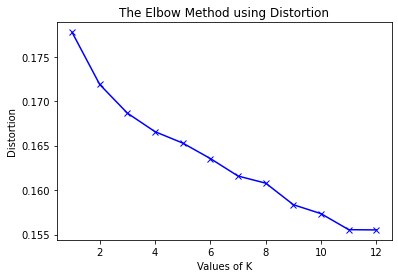

In [142]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

As seen in the figure above, there is a sudden slope change when the value of K = 9. Therefore, the model below will use 9 as a value of K.

### Run K-Clustering Algorithm

In [104]:
# set number of clusters
kclusters = 9


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 8, 8, 5, 1, 1, 1, 1, 1], dtype=int32)

In [105]:
# add clustering labels
node_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = nyc_nodes

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(node_venues_sorted.set_index('Node ID'), on='Node ID')

manhattan_merged.head() # check the last columns!

,Latitude,Longitude,Node ID,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,40.862651,-73.925556,Node 1,1,Pizza Place,Latin American Restaurant,Mexican Restaurant,Restaurant,Grocery Store,Bakery,Spanish Restaurant,Pharmacy,Bank,Supermarket
1,40.862651,-73.930512,Node 2,0,Wine Bar,Art Museum,Museum,Video Game Store,Mexican Restaurant,Tapas Restaurant,Mobile Phone Shop,Chinese Restaurant,Pharmacy,Bakery
2,40.862651,-73.935469,Node 3,7,Art Museum,Garden,Fried Chicken Joint,Park,Museum,Gift Shop,Café,Dog Run,American Restaurant,Plaza
3,40.859325,-73.925556,Node 4,1,Pizza Place,Grocery Store,Fast Food Restaurant,Donut Shop,Lounge,Bakery,Bar,Salad Place,Spanish Restaurant,Video Game Store
4,40.859325,-73.930512,Node 5,0,Bar,Pizza Place,Discount Store,Park,Chinese Restaurant,Dog Run,Spa,American Restaurant,Garden,Deli / Bodega


As seen in the table above, each node is now classified in one of the 9 clusters using the K-Clustering algorithm

## Part 4: Review K-Clustering Model Results

The best way to review the K-Clustering results is to create a map of all the datapoints colored by cluster. As seen in the map below, each neighborhood appears to have their own cluster. As someone currently living in New York, these results make sense to the geography of each neighborhood. For example, the orange cluster are more residential neighborhoods with a variety of smaller restaurants. The blue cluster however, is more commercial with more larger chain restaurants. 

In [106]:
# create map

map_clusters = folium.Map(location=[nylatitude, nylongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Node ID'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# WeWork Location Analysis

Now that we've completed the above analysis, how can we use this information to drive business decisions? This model can be used for any business that has multiple locations across manhattan. Each location can be assigned to a classifier established above, and use this information to draw insights on ideal expansion locations.

In the below model we will use WeWork, a prominent commercial real estate company in Manhattan, as an example.

## Part 1: Webscrape WeWork Website to Retrieve All New York Locations

To use this model, we need to first get a list of all Manhattan WeWork locations. Each New York location can be found on the company's website. By using the BeautifulSoup library, we can webscrape for the addresses.

In [107]:
#request HTML data
url = 'https://www.wework.com/l/new-york-city--NY'
page = requests.get(url)
soup = BeautifulSoup(page.text,'html.parser')

In [108]:
ww_address = []
for address in soup.find_all('div',class_='ray-text--body building-card__address'):
    ww_address.append(address.text)
ww_address

['980 6th Avenue New York NY 10018',
 '16 East 34th Street New York NY 10016',
 '229 West 36th Street New York NY 10018',
 '430 Park Avenue New York NY 10022',
 '28-07 Jackson Ave 5th Floor Long Island City NY 11101',
 '8 W 126th Street New York NY 10027',
 '140 Crosby St New York NY 10012',
 '214 W 29th Street New York NY 10001',
 '368 9th Ave New York NY 10001',
 '880 3rd Avenue New York NY 10022',
 '175 Varick Street New York NY 10014',
 '450 Lexington Ave New York NY 10017',
 '199 Water Street New York NY 10038',
 '25 Broadway 9th Floor New York NY 10004',
 '200 Broadway New York NY 10038',
 '609 5th Avenue New York NY 10017',
 '428 Broadway New York NY 10013',
 '33 Irving Pl New York NY 10003',
 '575 Lexington Avenue New York NY 10022',
 '750 Lexington Ave New York NY 10022',
 '27 E 28th St New York NY 10016',
 '450 Park Avenue South New York NY 10016',
 '500 7th Avenue New York NY 10018',
 '379 West Broadway 2nd Floor New York NY 10012',
 '18 West 18th Street New York NY 10011',


## Part 2: Convert WeWork Adresses into Latitude and Longitude Coordinates

Now that we have all of the New York WeWork Addresses, we can convert the addresses into latitude and longitude format by using the geopy library. Unfortunatley, the geolocator API is not perfect, and we need to make modifications to our data before running this function. See the annotations below for these modifications.

In [110]:
wework_locations = []
bad_address = []
for places in ww_address:
    try:
        places = re.sub(r' \w+\ Floor', '', places,flags=re.IGNORECASE) #geolocator can't detect address with floor numbers
        places = re.sub(r'Broadway Street','Broadway',places) #WeWork listed an address as 'Broadway Street' but the address is just 'Broadway'
        places = re.sub(r'1 Dock 72 Way Brooklyn NY 11205','Dock 72 at the Brooklyn Navy Yard',places)#This new location is not yet recognized in geolocator, however 'Dock 72 at the Brooklyn Navy Yard' is recognized 
        
        geolocator = Nominatim(user_agent="DerekProject")
        location = geolocator.geocode(places)
        wework_locations.append([location.latitude, location.longitude])
    except AttributeError:
        print("Bad Address:" + places)
wework_locations = pd.DataFrame(wework_locations,columns = ['Latitude','Longitude'])
wework_locations['Address'] = ww_address

In [112]:
wework_locations.head(5)

,Latitude,Longitude,Address
0,40.751310,-73.986428,980 6th Avenue New York NY 10018
1,40.747895,-73.983667,16 East 34th Street New York NY 10016
2,40.753031,-73.990845,229 West 36th Street New York NY 10018
3,40.760721,-73.971706,430 Park Avenue New York NY 10022
4,40.746898,-73.943108,28-07 Jackson Ave 5th Floor Long Island City N...


As seen in the table above, we were succesfully able to extract the latitude and longitude amounts for each address and create a dataframe. In our next step, we need to remove any locations outside of manhattan which is out of scope for this analysis.

In [160]:
manhattan_wework_locations =[]
for lat, lon, add in zip(wework_locations['Latitude'], wework_locations['Longitude'],wework_locations['Address']):
    for a in neighborhoodshape:
        polygon = Polygon(a) # create polygon
        point = Point(lon,lat) # create point
        manhattan_wework_locations.append([point.within(polygon),lat,lon,add])
manhattan_wework_locations = pd.DataFrame(manhattan_wework_locations,columns = ['TF','Latitude','Longitude','Address'])
manhattan_wework_locations.head(5)

,TF,Latitude,Longitude,Address
0,False,40.75131,-73.986428,980 6th Avenue New York NY 10018
1,False,40.75131,-73.986428,980 6th Avenue New York NY 10018
2,False,40.75131,-73.986428,980 6th Avenue New York NY 10018
3,False,40.75131,-73.986428,980 6th Avenue New York NY 10018
4,False,40.75131,-73.986428,980 6th Avenue New York NY 10018


In [161]:
manhattan_wework_locations = manhattan_wework_locations[manhattan_wework_locations['TF']==True].reset_index(drop = True)
manhattan_wework_locations = manhattan_wework_locations.drop(columns = 'TF')
manhattan_wework_locations.head(5)

,Latitude,Longitude,Address
0,40.751310,-73.986428,980 6th Avenue New York NY 10018
1,40.747895,-73.983667,16 East 34th Street New York NY 10016
2,40.753031,-73.990845,229 West 36th Street New York NY 10018
3,40.760721,-73.971706,430 Park Avenue New York NY 10022
4,40.807154,-73.942150,8 W 126th Street New York NY 10027


Now that we have each latitude and longitude point established, let's take a look at a map and see the location of each WeWork.

In [115]:
nylatitude = 40.758681
nylongitude = -73.983030
map_manhattan = folium.Map(location=[nylatitude, nylongitude], zoom_start=12)

# add markers to map
for lat, lng,add in zip(manhattan_wework_locations['Latitude'], manhattan_wework_locations['Longitude'],manhattan_wework_locations['Address']):
    label = '{}'.format(add)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan

## Part 3: Match WeWork Address to K-Clustering Data Point

In order to match each WeWork address to a K-clustering datapoint, we must find the closest k - clustering data point to each address using the function below

In [162]:
closest_node = []
for lat,long,add in zip(manhattan_wework_locations['Latitude'], manhattan_wework_locations['Longitude'],manhattan_wework_locations['Address']):
    nodedist = []
    for nlat, nlong,node in zip(nyc_nodes['Latitude'], nyc_nodes['Longitude'],nyc_nodes['Node ID']):
        nodedist.append([(geodesic((lat,long),(nlat,nlong)).meters),node])
    closest_node.append(min(nodedist))
for row in closest_node:
    del row[0]
manhattan_wework_locations['Node ID'] = closest_node
manhattan_wework_locations.head(5)

,Latitude,Longitude,Address,Node ID
0,40.751310,-73.986428,980 6th Avenue New York NY 10018,[Node 206]
1,40.747895,-73.983667,16 East 34th Street New York NY 10016,[Node 214]
2,40.753031,-73.990845,229 West 36th Street New York NY 10018,[Node 207]
3,40.760721,-73.971706,430 Park Avenue New York NY 10022,[Node 186]
4,40.807154,-73.942150,8 W 126th Street New York NY 10027,[Node 77]


In [163]:
manhattan_wework_locations['Node ID'] = manhattan_wework_locations['Node ID'].str[0]
manhattan_wework_locations.head(5)

,Latitude,Longitude,Address,Node ID
0,40.751310,-73.986428,980 6th Avenue New York NY 10018,Node 206
1,40.747895,-73.983667,16 East 34th Street New York NY 10016,Node 214
2,40.753031,-73.990845,229 West 36th Street New York NY 10018,Node 207
3,40.760721,-73.971706,430 Park Avenue New York NY 10022,Node 186
4,40.807154,-73.942150,8 W 126th Street New York NY 10027,Node 77


Once the closest k - clustering point is established, match the Node ID to the cluster label previously established. Once the table is formatted correctly, map the locations by cluster label color.

In [164]:
manhattan_wework_locations['Node ID'] = manhattan_wework_locations['Node ID'].astype(str)
manhattan_merged['Node ID'] = manhattan_merged['Node ID'].astype(str)

In [165]:
wework_cluster = pd.merge(manhattan_wework_locations,manhattan_merged[['Node ID','Cluster Labels']],on='Node ID', how='left')

In [166]:
wework_cluster.head(5)

,Latitude,Longitude,Address,Node ID,Cluster Labels
0,40.751310,-73.986428,980 6th Avenue New York NY 10018,Node 206,3
1,40.747895,-73.983667,16 East 34th Street New York NY 10016,Node 214,3
2,40.753031,-73.990845,229 West 36th Street New York NY 10018,Node 207,3
3,40.760721,-73.971706,430 Park Avenue New York NY 10022,Node 186,3
4,40.807154,-73.942150,8 W 126th Street New York NY 10027,Node 77,5


In [167]:
# create map

map_clusters = folium.Map(location=[nylatitude, nylongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(wework_cluster['Latitude'], wework_cluster['Longitude'], wework_cluster['Node ID'], wework_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Part 4: Perform Additional WeWork Location Analysis

To demonstrate the usefulness of this analysis, I will go through a few scenarios someone could use this information to drive a business decision.

<ins>Scenario 1: WeWork is looking to expand</ins>

In this scenario, you are a part of WeWork's management team looking to expand to a new location. How do you decide which area of Manhattan to expand? Using this model, you can identify a new neighborhood to set up a location. 

The first thing you notice is the majority of locations are grouped as cluster \# 3 (light blue cluster). As a member of the WeWork management team, you should have financial data for each building. Are the buildings labeled as cluster \#3 more profitable than the other clusters? If so, it make sense to expand to a location near a cluster \#3 datapoint. If not, are there other locations more profitable and should you look into expanding near those cluster points?

As you can see, you can take this a step further with additional building financial data, but having cluster information can be usefull in identifying potential expansion locations.

<ins>Scenario 2: A competitor is looking to expand</ins>

In this scenario, you are a competitor of WeWork looking to expand. You do not have building level financial data for each WeWork location, but you are going to assume the locations in cluster \#3 are more profitable than other clusters -- why else would WeWork be so focused on expanding to these areas? However, a new location set too close to a currently established a WeWork may result in over competition. Based on this logic, expanding to a location near Lincoln Center is advisable. It is still within cluster \#3, but there are no WeWork location currently providing competition.


As a competitor, you should also have financial data for each of your buildings. You can run this model for any Manhattan address by modifying part 1 above, therefore, competitors can draw their own assumption over more profitable neighborhoods. 

Again, the more information a competitor has, the more useful the clustering analysis is during a decision making process. 


<ins>Scenario 3: A commercial real estate firm is looking to lease office space to WeWork</ins>

In this Scenario, you are a commercial real estate firm looking to sell office space to WeWork. Were do you think they are looking to expand next? From this analysis, it is apparent that they are looking locations within Cluster \#3. If the commercial real estate firm has a location to sell near Lincoln Center, they can use this model to persuade WeWork that expanding to this neighborhood is in WeWork's best interest. 

### Conclusion

By clustering Manhattan neighborhoods based upon the venues in the area, you can identify geographical similarities. Midtown Manhattan and the Financial District are not located near each other, but they share similar characteristics which make those areas potential areas for WeWork expansion. However, Midtown Manhattan and the Upper East Side are relatively close to each other, but will not make for an optimal expansion based upon neighborhood data.

This Model can be tailored to the needs of the user and can be run for any business with multiple locations in Manhattan.